In [1]:
import os
import json
import shutil
import numpy as np
import pandas as pd

from pathlib import Path
from citylearn.data import DataSet
from matplotlib import pyplot as plt
from src.utils.utils import set_seed

from tqdm import tqdm

# Set a fix seed for reproducibility

set_seed(0)

# Utils

In [ ]:
def shift_and_append(df, n):

    # Shift the DataFrame by n positions (downward)
    shifted_df = df.shift(n)
    
    # Collect the dropped values (the last n rows before the shift)
    dropped_values = df.iloc[:-n].reset_index(drop=True)
    
    # Replace the first n rows (now NaN) with the dropped values
    shifted_df.iloc[n:] = dropped_values.values
    
    return shifted_df

In [ ]:
def shift_and_concat(df, shifts):

    c = pd.DataFrame()
    noise = np.random.normal(0, 0.01, (df.shape[0]))
    
    for s in shifts:
        shifted_df = shift_and_append(df, s)
        shifted_df = shifted_df + noise
        c = pd.concat([c, shifted_df], axis=1)
        noise += np.random.normal(0, 0.01, (df.shape[0]))
    c.columns = [f'{df.name}_predicted_{abs(s)}h' for s in shifts]
    return c

In [ ]:
def convex_combination_of_df(df1, df2, alpha):

    comb = df1 * alpha + df2 * (1 - alpha)
    comb = comb.astype(df1.dtypes)

    return comb

In [6]:
def plot_energy_solution(sol, solar_generation):
    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
            
    ax1.plot(sol['load'], label='Load', marker='o')
    ax1.plot(sol['batt'], label='Battery energy', color='g', linestyle='--', marker='o')
    ax1.plot(solar_generation, label='Solar generation', marker='o')
    ax1.plot(sol['load'] + sol['batt'] - solar_generation, label='Total energy', color='m', linestyle='--', marker='o')

    ax2.plot(sol['soc'], label='State of charge', color='tab:red', marker='o')
    ax2.plot(sol['action'], label='Battery action', color='tab:purple', marker='o')

    ax1.set_xlabel('Time (hours)')
    ax2.set_xlabel('Time (hours)')
    ax1.set_ylabel('Energy (kWh)')
    ax2.set_ylabel('State of Charge')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    ax1.grid()
    ax2.grid()

    ax1.set_xticks(range(0, 24))
    ax2.set_xticks(range(0, 24))

    plt.show()

# Data generation

In [ ]:
def generate_data(
    solar_profile, batt_cap, load_ratio: float = 0.6
):
    
    batt_ratio = 1 - load_ratio
    
    sol = {
        'load': np.zeros(24),
        'batt': np.zeros(24),
        'action': np.zeros(24),
    }

    # Load and charge generation profiles

    stored = 0
    residual = 0

    for h, gen in enumerate(solar_profile):

        to_store = min(batt_ratio * gen, batt_cap - stored)
        residual = max(0, batt_ratio * gen - to_store)

        sol['load'][h] += load_ratio * gen + residual
        sol['batt'][h] += to_store

        stored += to_store

    # Find index of last generation timestep

    ix_last_gen = next((i for i, gen in enumerate(reversed(solar_profile)) if gen > 0), 0)
    ix_last_gen = len(solar_profile) - ix_last_gen

    # Distribute the stored energy unirmly over the last steps after the last generation

    steps = len(solar_profile) - ix_last_gen - 1
    stored_per_step = stored / steps

    for h in range(ix_last_gen, len(solar_profile) - 1):

        sol['load'][h] += stored_per_step
        sol['batt'][h] -= stored_per_step

    # Adjust action according to capacity

    sol['action'] = sol['batt']
    sol['action'] /= batt_cap

    # Create SoC by doing the cumulative sum of the action

    sol['soc'] = np.cumsum(sol['action'])
    
    return sol

In [ ]:
def generate_naive_data_from_ref(
    base_dataset: str = 'citylearn_challenge_2022_phase_all', dest_folder: str = 'data/', building_no: int = 5, batt_cap: float = 1.0,
    load_ratio: float = 0.6, simplify_solar: bool = False, selling_margin: float = 0.1
):

    # Generate name based on the number of buildings

    dest_folder = os.path.join(dest_folder, f"naive_{building_no}_buildings{'_simple' if simplify_solar else ''}/")

    # If the directory exists, delete it and create the subfolders
    
    shutil.rmtree(dest_folder, ignore_errors=True)
    
    # Creat destination folder exists including the subfolders

    Path(dest_folder).mkdir(parents=True, exist_ok=True)

    # Get reference schema

    schema = DataSet.get_schema(base_dataset)

    # Reduce the number of buildings to 1

    schema['buildings'] = {f'Building_{i + 1}': schema['buildings'][f'Building_{i + 1}'] for i in range(building_no)}

    # Extract the base weather, emissions and pricing data (doesn't change among buildings)

    base_weather = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['weather']))
    base_pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))
    base_emissions = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['carbon_intensity']))

    # Add column to base_pricing to save the selling price

    base_pricing['selling_pricing'] = 0.0

    # Read the base schema and process the json

    # We need just to store the load and optimal actions for each building
    # 0 - Load
    # 1 - Battery charge/discharge energy
    # 2 - SoC
    # 3 - Action

    building_data = np.array([[[0.] * 4 for _ in range(365 * 24)] for _ in range(building_no)])
    base_csvs = []

    for building_no, (building_name, info) in enumerate(schema['buildings'].items()):

        # Create custom building CSVs

        base_csv = pd.read_csv(os.path.join(schema['root_directory'], info['energy_simulation']))
        solar_generation = base_csv['solar_generation'].values / 1000
        base_csvs.append(base_csv)

        # Pass one day at a time the solar generation from the building data

        with tqdm(total=365, desc=f'Processing Building {building_no + 1}') as pbar:

            for day in range(365):

                solar_profile = solar_generation[day * 24:(day + 1) * 24]

                # Populate the selling price dataframe with the lowest price of the day

                base_pricing.loc[day * 24:(day + 1) * 24 - 1, 'selling_pricing'] = base_pricing.loc[
                    day * 24:(day + 1) * 24 - 1, 'electricity_pricing'
                ].min() * (1 - selling_margin)

                if simplify_solar:

                    solar_profile = np.where(solar_profile > 0, solar_profile.max(), solar_profile)
                    base_csv.loc[day * 24:(day + 1) * 24 - 1, 'solar_generation'] = base_csv['solar_generation'][
                        day * 24:(day + 1) * 24
                    ].apply(lambda x: 0 if x == 0 else solar_profile.max()) * 1000
                    
                sol = generate_data(
                    solar_profile=solar_profile, batt_cap=batt_cap, load_ratio=load_ratio
                )

                building_data[building_no, day * 24:(day + 1) * 24, 0] += sol['load']
                building_data[building_no, day * 24:(day + 1) * 24, 1] += sol['batt']
                building_data[building_no, day * 24:(day + 1) * 24, 2] += sol['soc']
                building_data[building_no, day * 24:(day + 1) * 24, 3] += sol['action']

                pbar.set_postfix({'building': building_name, 'day': day})

                pbar.update(1)

    # Update the base csv with the new data

    for building_no, (building_name, _) in enumerate(schema['buildings'].items()):

        base_csvs[building_no]['non_shiftable_load'] = building_data[building_no,:,0].clip(min=0)

        # Save predictions (synthetic) for the building

        shifts = [-4, -6, -12, -24] # 4, 6, 12, 24 hours in the future

        base_csvs[building_no] = pd.concat([base_csvs[building_no], shift_and_concat(
            df=base_csvs[building_no]['non_shiftable_load'],
            shifts=shifts
        )], ignore_index=False, axis=1)

        base_csvs[building_no].to_csv(os.path.join(dest_folder, f'{building_name}.csv'), index=False)

        # Save batt action and soc in a separate file to avoid issues loading CityLearn

        sol_csv = pd.DataFrame(columns=['batt', 'soc'], index=range(365 * 24))

        sol_csv['batt'] = building_data[building_no,:,1]
        sol_csv['soc'] = building_data[building_no,:,2]
        sol_csv['action'] = building_data[building_no,:,3]

        sol_csv.to_csv(os.path.join(dest_folder, f'sol_{building_name}.csv'), index=False)

        # Update the schema with the new paths

        schema['buildings'][building_name]['energy_simulation'] = f'{building_name}.csv'

        # Update the schema to guarantee an ideal battery

        schema['buildings'][building_name]['electrical_storage']['attributes'] = {
            "capacity": batt_cap,
            "efficiency": 1.0,
            "capacity_loss_coefficient": 0.0,
            "loss_coefficient": 0.0,
            "nominal_power": batt_cap,
            "power_efficiency_curve": [[0, 1],[0.3, 1],[0.7, 1],[0.8, 1],[1, 1]],
            "capacity_power_curve": [[0.0, 1],[0.8, 1],[1.0, 1]],
        }

        # Update schema with the new observations (selling price, non-shiftable load predictions)

        base_dict = { 'active': True, 'shared_in_central_agent': False}

        schema['observations']['selling_pricing'] = { **base_dict, "shared_in_central_agent": True }
        schema['observations']['non_shiftable_load_predicted_4h'] = base_dict
        schema['observations']['non_shiftable_load_predicted_6h'] = base_dict
        schema['observations']['non_shiftable_load_predicted_12h'] = base_dict
        schema['observations']['non_shiftable_load_predicted_24h'] = base_dict

        # Set nominal power to 1 for solar panel to simplify case

        schema['buildings'][building_name]['pv']['attributes']['nominal_power'] = 1.0

    # Write pricing and emissions data to the destination folder

    base_weather.to_csv(os.path.join(dest_folder, 'weather.csv'), index=False)
    base_pricing.to_csv(os.path.join(dest_folder, 'pricing.csv'), index=False)
    base_emissions.to_csv(os.path.join(dest_folder, 'carbon_intensity.csv'), index=False)

    # Save the new schema in the destination folder

    schema['root_directory'] = dest_folder

    with open(os.path.join(dest_folder, 'schema.json'), 'w') as f:
        json.dump(schema, f, indent=4)

    return dest_folder

In [ ]:
def create_eval_data_from_ref(ref_dir: str = 'data/naive_data/'):

    # Get schema file

    with open(os.path.join(ref_dir, 'schema.json'), 'r') as f:
        schema = json.load(f)

    # Read the original files in folder

    building_files = []

    for csv_file in sorted(Path(ref_dir).glob("Building_*.csv")):
                    
        df = pd.read_csv(csv_file)
        building_files.append(df)

    sol_files = []

    for csv_file in sorted(Path(ref_dir).glob("sol_*.csv")):
                    
        df = pd.read_csv(csv_file)
        sol_files.append(df)

    # Battery characteristics

    batt_caps = []

    for building in schema['buildings'].values():
        batt_caps.append(building['electrical_storage']['attributes']['capacity'])

    combinations = []

    for i in range(len(schema['buildings'])):

        # Pick a random alpha

        alpha = np.random.rand()

        # Pick two random buildings

        building_a, building_b = np.random.choice(len(schema['buildings']), 2, replace=False)

        combinations.append((building_a, building_b))

        # Convex combination of the solutions

        sol_1 = sol_files[building_a]
        sol_2 = sol_files[building_b]

        sol = convex_combination_of_df(sol_1, sol_2, alpha)

        # Convex combination of the buildings, but excluding the columns that should not be combined

        building_1 = building_files[building_a]
        building_2 = building_files[building_b]

        building = convex_combination_of_df(building_1, building_2, alpha)

        # Save the new files in the eval subfolder, first check that the folder exists

        Path(os.path.join(ref_dir, 'eval')).mkdir(parents=True, exist_ok=True)

        building.to_csv(os.path.join(ref_dir, 'eval', f'Building_{i + 1}.csv'), index=False)
        sol.to_csv(os.path.join(ref_dir, 'eval', f'sol_Building_{i + 1}.csv'), index=False)

        # Modify the schema to specify battery characteristics

        schema['buildings'][f'Building_{i + 1}']['electrical_storage']['attributes'] = {
            "capacity": np.mean([batt_caps[building_a], batt_caps[building_b]]),
            "efficiency": 1.0,
            "capacity_loss_coefficient": 0.0,
            "loss_coefficient": 0.0,
            "nominal_power": np.mean([batt_caps[building_a], batt_caps[building_b]]),
            "power_efficiency_curve": [[0, 1],[0.3, 1],[0.7, 1],[0.8, 1],[1, 1]],
            "capacity_power_curve": [[0.0, 1],[0.8, 1],[1.0, 1]],
        }

    # Modify the schema to point to the new files

    schema['root_directory'] = os.path.join(ref_dir, 'eval')

    # Save schema

    with open(os.path.join(ref_dir, 'eval', 'schema.json'), 'w') as f:
        json.dump(schema, f, indent=4)

    # Save the rest of relevant files

    for file in ['weather.csv', 'pricing.csv', 'carbon_intensity.csv']:
        shutil.copyfile(os.path.join(ref_dir, file), os.path.join(ref_dir, 'eval', file))

    return combinations, building_files, sol_files

# Generate dataset

In [ ]:
# Define an assignation of energy consumption by levels

n_buildings = 2
batt_cap = 1.0
load_ratio = 0.6
simplify_solar = True

dest_folder = generate_naive_data_from_ref(
    building_no=n_buildings, batt_cap=batt_cap, load_ratio=load_ratio, simplify_solar=simplify_solar
)

combinations, building_files, sol_files = create_eval_data_from_ref(ref_dir=dest_folder)

## Checks on the generated data

In [4]:
dest_folder = 'data/naive_2_buildings_simple/'

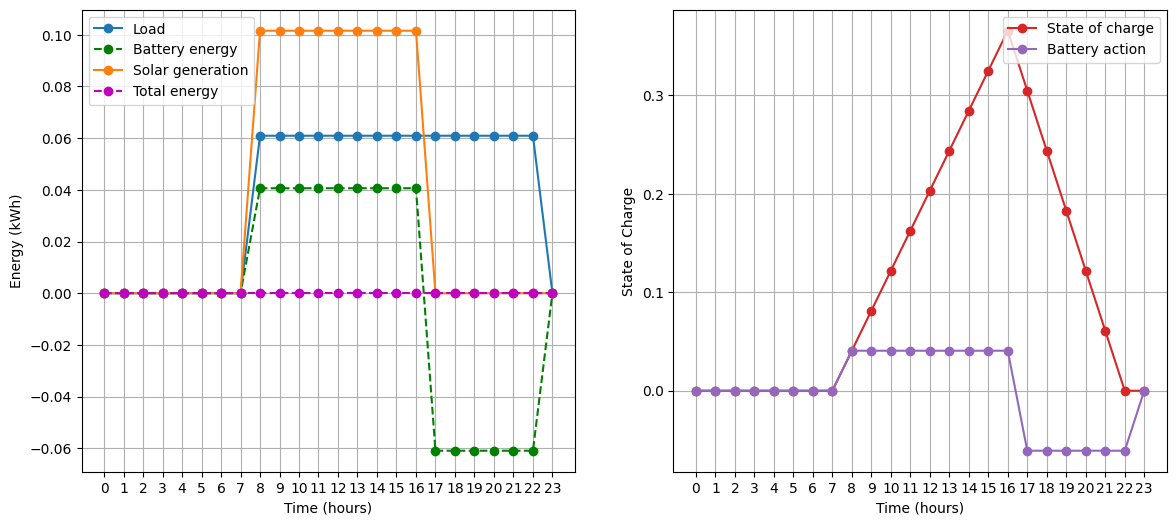

In [7]:
# Check data generated picking random days from random buildings

day_index = 4128#888#24 * 150
building_index = 0

with open(f'{dest_folder}schema.json', 'r') as f:
    schema = json.load(f)

building_name = f'Building_{building_index + 1}'
building_csv = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings'][building_name]['energy_simulation']))
sol_csv = pd.read_csv(os.path.join(schema['root_directory'], f'sol_{building_name}.csv'))

solar_generation = building_csv['solar_generation'].values / 1000
load = building_csv['non_shiftable_load'].values
batt = sol_csv['batt'].values
soc = sol_csv['soc'].values
action = sol_csv['action'].values
battery_capacity = schema['buildings'][building_name]['electrical_storage']['attributes']['capacity']

plot_energy_solution({
    'load': load[day_index:day_index + 24],
    'action': action[day_index:day_index + 24],
    'batt': batt[day_index:day_index + 24],
    'soc': soc[day_index:day_index + 24]
}, solar_generation[day_index:day_index + 24])

In [ ]:
# Check net energy of whole year

with open(f'{dest_folder}schema.json', 'r') as f:
    schema = json.load(f)

for b_ix in range(len(schema['buildings'])):

    building_name = f'Building_{b_ix + 1}'
    building_csv = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings'][building_name]['energy_simulation']))
    sol_csv = pd.read_csv(os.path.join(schema['root_directory'], f'sol_{building_name}.csv'))

    solar_generation = building_csv['solar_generation'].values / 1000
    load = building_csv['non_shiftable_load'].values
    batt = sol_csv['batt'].values
    soc = sol_csv['soc'].values
    
    # Compute net electricity

    net_energy_no_batt = load - solar_generation
    net_energy = load - solar_generation + batt

    # Compute energy cost

    pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))['electricity_pricing'].values
    selling_pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))['selling_pricing'].values
    
    cost_no_batt = (net_energy_no_batt.clip(min=0) * pricing + net_energy_no_batt.clip(max=0) * selling_pricing).sum()
    cost = (net_energy.clip(min=0) * pricing + net_energy.clip(max=0) * selling_pricing).sum()

    # Compute carbon intensity

    emissions = pd.read_csv(os.path.join(schema['root_directory'], 'carbon_intensity.csv'))['carbon_intensity'].values

    emissions_no_batt = (emissions * net_energy_no_batt.clip(min=0)).sum()
    emissions = (emissions * net_energy.clip(min=0)).sum()

    print(f'Building {b_ix + 1}')
    print(f'Avg. Hour Cost No batt: {cost_no_batt} - With batt: {cost}')
    print(f'Avg. Hour Emissions No batt: {emissions_no_batt} - With batt: {emissions}')

In [8]:
# Check net energy for a given period

day_index = 888

with open(f'{dest_folder}schema.json', 'r') as f:
    schema = json.load(f)

for b_ix in range(len(schema['buildings'])):

    building_name = f'Building_{b_ix + 1}'
    building_csv = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings'][building_name]['energy_simulation']))
    sol_csv = pd.read_csv(os.path.join(schema['root_directory'], f'sol_{building_name}.csv'))

    solar_generation = building_csv['solar_generation'].values[day_index:day_index+24] / 1000
    load = building_csv['non_shiftable_load'].values[day_index:day_index+24]
    batt = sol_csv['batt'].values[day_index:day_index+24]
    soc = sol_csv['soc'].values[day_index:day_index+24]

    # Compute net electricity

    net_energy_no_batt = load - solar_generation
    net_energy = load - solar_generation + batt

    # Compute energy cost

    pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))['electricity_pricing'].values[day_index:day_index+24]
    selling_pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))['selling_pricing'].values[day_index:day_index+24]

    cost_no_batt = (net_energy_no_batt.clip(min=0) * pricing + net_energy_no_batt.clip(max=0) * selling_pricing).sum()
    cost = (net_energy.clip(min=0) * pricing).sum() + (net_energy.clip(max=0) * selling_pricing).sum()

    # Compute carbon intensity

    emissions = pd.read_csv(os.path.join(schema['root_directory'], 'carbon_intensity.csv'))['carbon_intensity'].values[day_index:day_index+24]

    emissions_no_batt = (emissions * net_energy_no_batt.clip(min=0)).sum()
    emissions = (emissions * net_energy.clip(min=0)).sum()

    print(f'Building {b_ix + 1}')
    print(f'Avg. Hour Cost No batt: {cost_no_batt} - With batt: {cost}')
    print(f'Avg. Hour Emissions No batt: {emissions_no_batt} - With batt: {emissions}')

Building 1
Avg. Hour Cost No batt: 0.18199999999999997 - With batt: -3.2973623831367154e-17
Avg. Hour Emissions No batt: 0.158921705 - With batt: 0.0
Building 2
Avg. Hour Cost No batt: 0.18199999999999994 - With batt: -7.006895064165521e-17
Avg. Hour Emissions No batt: 0.158921705 - With batt: 0.0


In [12]:
net_energy_no_batt, pricing, selling_pricing

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.23804666, -0.23804666, -0.23804666,
        -0.23804666, -0.04781338,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.25      ,
         0.25      ,  0.25      ,  0.25      ,  0.        ]),
 array([0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22,
        0.22, 0.22, 0.22, 0.22, 0.22, 0.54, 0.54, 0.54, 0.54, 0.54, 0.22,
        0.22, 0.22]),
 array([0.198, 0.198, 0.198, 0.198, 0.198, 0.198, 0.198, 0.198, 0.198,
        0.198, 0.198, 0.198, 0.198, 0.198, 0.198, 0.198, 0.198, 0.198,
        0.198, 0.198, 0.198, 0.198, 0.198, 0.198]))

In [ ]:
# Check net energy for a given period

day_index = 5832

with open(f'{dest_folder}schema.json', 'r') as f:
    schema = json.load(f)

for b_ix in range(len(schema['buildings'])):

    building_name = f'Building_{b_ix + 1}'
    building_csv = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings'][building_name]['energy_simulation']))
    sol_csv = pd.read_csv(os.path.join(schema['root_directory'], f'sol_{building_name}.csv'))

    solar_generation = building_csv['solar_generation'].values[day_index:day_index+24] / 1000
    load = building_csv['non_shiftable_load'].values[day_index:day_index+24]
    batt = sol_csv['batt'].values[day_index:day_index+24]
    soc = sol_csv['soc'].values[day_index:day_index+24]

    # Compute net electricity

    net_energy_no_batt = load - solar_generation
    net_energy = load - solar_generation + batt

    # Compute energy cost

    pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))['electricity_pricing'].values[day_index:day_index+24]
    
    cost_no_batt = (net_energy_no_batt * pricing).sum()
    cost = (net_energy * pricing).sum()

    # Correct energy cost

    correct_cost_no_batt = (net_energy_no_batt.clip(min=0) * pricing + net_energy_no_batt.clip(max=0) * 0.9 * pricing).sum()
    correct_cost = (net_energy.clip(min=0) * pricing + net_energy.clip(max=0) * 0.9 * pricing).sum()

    # Compute carbon intensity

    emissions = pd.read_csv(os.path.join(schema['root_directory'], 'carbon_intensity.csv'))['carbon_intensity'].values[day_index:day_index+24]

    emissions_no_batt = (emissions * net_energy_no_batt.clip(min=0)).sum()
    emissions = (emissions * net_energy.clip(min=0)).sum()

    print(f'Building {b_ix + 1}')
    print(f'Avg. Hour Cost No batt: {cost_no_batt} - With batt: {cost}')
    print(f'Avg. Hour Correct Cost No batt: {correct_cost_no_batt} - With batt: {correct_cost}')
    print(f'Avg. Hour Emissions No batt: {emissions_no_batt} - With batt: {emissions}')

## Checkings on Eval data

In [ ]:
# Compare in a plot the convex combination of the predictions with the prediction of the convex combination for a given day

day_index = 5832
building_index = 0

b1, b2 = combinations[building_index]

pred_1 = building_files[b1]
pred_2 = building_files[b2]

# Read the combination from csv

comb = pd.read_csv(f'{dest_folder}eval/Building_{building_index + 1}.csv')

plt.plot(pred_1['non_shiftable_load_predicted_4h'][day_index:day_index + 24], label=f'Building {b1} - Load', marker='o')
plt.plot(pred_2['non_shiftable_load_predicted_4h'][day_index:day_index + 24], label=f'Building {b2} - Load', marker='o')
plt.plot(comb['non_shiftable_load_predicted_4h'][day_index:day_index + 24], label='Combination - Load', marker='o')

plt.legend()
plt.grid()
plt.show()

In [ ]:
# Compare in a plot the convex combination of the buildings with the building of the convex combination for a given day

day_index = 48

b1, b2 = combinations[building_index]

building_1 = building_files[b1]
building_2 = building_files[b2]

# Read the combination from csv

comb = pd.read_csv(f'{dest_folder}eval/Building_{building_index + 1}.csv')

plt.plot(building_1['solar_generation'][day_index:day_index + 24], label=f'Building {b1} - Load', marker='o')
plt.plot(building_2['solar_generation'][day_index:day_index + 24], label=f'Building {b2} - Load', marker='o')
plt.plot(comb['solar_generation'][day_index:day_index + 24], label='Combination - Load', marker='o')

plt.legend()
plt.grid()
plt.show()

In [ ]:
# Check data generated picking random days from random buildings

day_index = 8760-24
building_index = 1

comb = pd.read_csv(f'{dest_folder}/eval/Building_{building_index + 1}.csv')
sol = pd.read_csv(f'{dest_folder}/eval/sol_Building_{building_index + 1}.csv')

plot_energy_solution({
    'load': comb['non_shiftable_load'].values[day_index:day_index + 24],
    'batt': sol['batt'].values[day_index:day_index + 24],
    'soc': sol['soc'].values[day_index:day_index + 24],
    'action': sol['action'].values[day_index:day_index + 24],
}, comb['solar_generation'].values[day_index:day_index + 24] / 1000)